<a href="https://colab.research.google.com/github/melhartu/BelcorpHackathon2024/blob/main/BelcorpHackaton2024_BeautyCreators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beauty Creators - Belcorp Hackathon 2024**
### **Nombre**: Melissa Hartmann Ugaz, Brenda Jauregui, Giuliana Chicoma, Anna Albirena y Marco Panta

The code below explains the data processing flow intended to be done in AWS Cloud. The script uses the AWS SDK for Python (Boto3) to interact with AWS services.

###**Data Sources:**

***STRUCTURED DATA:***

* ~/rawclients.csv: Raw data of clients

* ~/rawconslutants.csv: Raw data of consultants

* ~/rawproducts092024.csv: Raw data of products of catalogue SEP 2024

* ~/rawproducts102024.csv: Raw data of products of catalogue OCT 2024

* ~/rawpurchases.csv: Raw data of purchases SEP-OCT 2024


***UNSTRUCTURED DATA:***

* ~/chatcliente.pdf: Example of exported chat conversation of client and consultant.

### **1. Data Cleaning Pre AWS ML/ AI tools Processing**

This section works as an example of how the data would be cleaned.

In [ ]:
import pandas as pd # To load and manipulate data
import boto3        # To interact with AWS services
import os           # To handle file operations and manage the environment
import time         # To work with time-based functionalities
import PyPDF2       # To process and extract information from PDF files
import json         # To serialize and deserialize data in JSON format

# Set up AWS clients
s3_client = boto3.client('s3')
glue_client = boto3.client('glue')
personalize_client = boto3.client('personalize')
personalize_runtime_client = boto3.client('personalize-runtime')
sagemaker_client = boto3.client('sagemaker')
sagemaker_runtime_client = boto3.client('sagemaker-runtime')
comprehend_client = boto3.client('comprehend')


# Define S3 buckets
bucket_raw = 'rawdata'
bucket_cleaned = 'cleandata'
bucket_personalize = 'processedpersonalize'      # Bucket to store processed personalize data
bucket_personalize_model = 'model_personalize'   # Bucket to store model data
bucket_sagemaker = 'processedsagemaker'
bucket_sagemaker_model = 'model_sagemaker'
bucket_comprehend = 'processedcomprehend'
bucket_comprehend_model = 'model_comprehend'

# Degine the file paths
pdf_file_path = 'chatcliente.pdf'
file_paths = {
    'clients': '/rawclients.csv',
    'consultants': '/rawconsultants.csv',
    'products_sep': '/rawproducts092024.csv',
    'products_oct': '/rawproducts102024.csv',
    'purchases': '/rawpurchases.csv',
}

# Function to upload files to S3
def upload_to_s3(file_name, object_name):
    try:
        s3_client.upload_file(file_name, bucket_raw, object_name)
        print(f'Successfully uploaded {file_name} to {bucket_raw}/{object_name}')
    except Exception as e:
        print(f'Failed to upload {file_name}: {str(e)}')

# Function to process clients data
def process_clients():
    df = pd.read_csv(os.path.expanduser(file_paths['clients']))
    print("\nProcessing clients data...")
    print(df.head())

    # Data cleaning: Remove duplicates and fill missing values
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    cleaned_file_name = 'cleaned_clients.csv'
    df.to_csv(cleaned_file_name, index=False)
    upload_to_s3(cleaned_file_name, f'cleaned_data/{cleaned_file_name}')

# Function to process consultants data
def process_consultants():
    df = pd.read_csv(os.path.expanduser(file_paths['consultants']))
    print("\nProcessing consultants data...")
    print(df.head())

    # Data cleaning
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    cleaned_file_name = 'cleaned_consultants.csv'
    df.to_csv(cleaned_file_name, index=False)
    upload_to_s3(cleaned_file_name, f'cleaned_data/{cleaned_file_name}')

# Function to process products data for September
def process_products_sep():
    df = pd.read_csv(os.path.expanduser(file_paths['products_sep']))
    print("\nProcessing September products data...")
    print(df.head())

    # Data cleaning
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    cleaned_file_name = 'cleaned_products_sep.csv'
    df.to_csv(cleaned_file_name, index=False)
    upload_to_s3(cleaned_file_name, f'cleaned_data/{cleaned_file_name}')

# Function to process products data for October
def process_products_oct():
    df = pd.read_csv(os.path.expanduser(file_paths['products_oct']))
    print("\nProcessing October products data...")
    print(df.head())

    # Data cleaning
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    cleaned_file_name = 'cleaned_products_oct.csv'
    df.to_csv(cleaned_file_name, index=False)
    upload_to_s3(cleaned_file_name, f'cleaned_data/{cleaned_file_name}')

# Function to process purchases data
def process_purchases():
    df = pd.read_csv(os.path.expanduser(file_paths['purchases']))
    print("\nProcessing purchases data...")
    print(df.head())

    # Data cleaning
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    cleaned_file_name = 'cleaned_purchases.csv'
    df.to_csv(cleaned_file_name, index=False)
    upload_to_s3(cleaned_file_name, f'cleaned_data/{cleaned_file_name}')

# Function to create Glue table for cleaned data
def create_glue_table(database_name, table_name, columns):
    response = glue_client.create_table(
        DatabaseName=database_name,
        TableInput={
            'Name': table_name,
            'StorageDescriptor': {
                'Columns': columns,
                'Location': f's3://{bucket_raw}/cleaned_data/',
                'InputFormat': 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat',
                'OutputFormat': 'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat',
                'Compressed': False,
            },
            'TableType': 'EXTERNAL_TABLE'
        }
    )
    print(f'Glue table {table_name} created in database {database_name}.')

# Define database and table names
database_name = 'your_database_name'
clients_columns = [
    {'Name': 'cod_cliente', 'Type': 'string'},
    {'Name': 'cod_pais', 'Type': 'string'},
    {'Name': 'fec_creacion', 'Type': 'timestamp'},
    {'Name': 'des_nombre_cliente', 'Type': 'string'},
    {'Name': 'des_email', 'Type': 'string'},
    {'Name': 'fec_modificacion', 'Type': 'timestamp'},
    {'Name': 'des_direccion', 'Type': 'string'},
    {'Name': 'age', 'Type': 'int'},
    {'Name': 'attributes', 'Type': 'string'}
]

consultants_columns = [
    {'Name': 'codpais', 'Type': 'string'},
    {'Name': 'codebelista', 'Type': 'string'},
    {'Name': 'desnombre', 'Type': 'string'},
    {'Name': 'desapepaterno', 'Type': 'string'},
    {'Name': 'docidentidad', 'Type': 'string'},
    {'Name': 'tipodocidentidad', 'Type': 'string'},
    {'Name': 'desestadocivil', 'Type': 'string'},
    {'Name': 'desdireccion', 'Type': 'string'},
    {'Name': 'aniocampanaingreso', 'Type': 'int'},
    {'Name': 'fechanacimiento', 'Type': 'date'},
    {'Name': 'fecharegistro', 'Type': 'date'}
]

products_columns = [
    {'Name': 'codsap', 'Type': 'string'},
    {'Name': 'desproducto', 'Type': 'string'},
    {'Name': 'desunidadnegocio', 'Type': 'string'},
    {'Name': 'desmarca', 'Type': 'string'},
    {'Name': 'descategoria', 'Type': 'string'},
    {'Name': 'dessubcategoria', 'Type': 'string'},
    {'Name': 'desclase', 'Type': 'string'},
    {'Name': 'desgrupoarticulo', 'Type': 'string'},
    {'Name': 'largo', 'Type': 'float'},
    {'Name': 'ancho', 'Type': 'float'},
    {'Name': 'volumen', 'Type': 'float'},
    {'Name': 'pesobruto', 'Type': 'float'},
    {'Name': 'atributos', 'Type': 'string'},
    {'Name': 'costo', 'Type': 'float'},
    {'Name': 'catalogo', 'Type': 'string'},
    {'Name': 'descuento', 'Type': 'float'}
]

purchases_columns = [
    {'Name': 'Client', 'Type': 'string'},
    {'Name': 'desproducto', 'Type': 'string'},
    {'Name': 'quantity', 'Type': 'int'},
    {'Name': 'Cost_dollars', 'Type': 'float'},
    {'Name': 'Offer', 'Type': 'string'},
    {'Name': 'Cost_total', 'Type': 'float'},
    {'Name': 'Discount_consultant', 'Type': 'float'},
    {'Name': 'Total_earned', 'Type': 'float'},
    {'Name': 'Date', 'Type': 'date'}
]

# Process each data file
process_clients()
process_consultants()
process_products_sep()
process_products_oct()
process_purchases()

# Create Glue tables for cleaned data
create_glue_table(database_name, 'cleaned_clients', clients_columns)
create_glue_table(database_name, 'cleaned_consultants', consultants_columns)
create_glue_table(database_name, 'cleaned_products_sep', products_columns)
create_glue_table(database_name, 'cleaned_products_oct', products_columns)
create_glue_table(database_name, 'cleaned_purchases', purchases_columns)


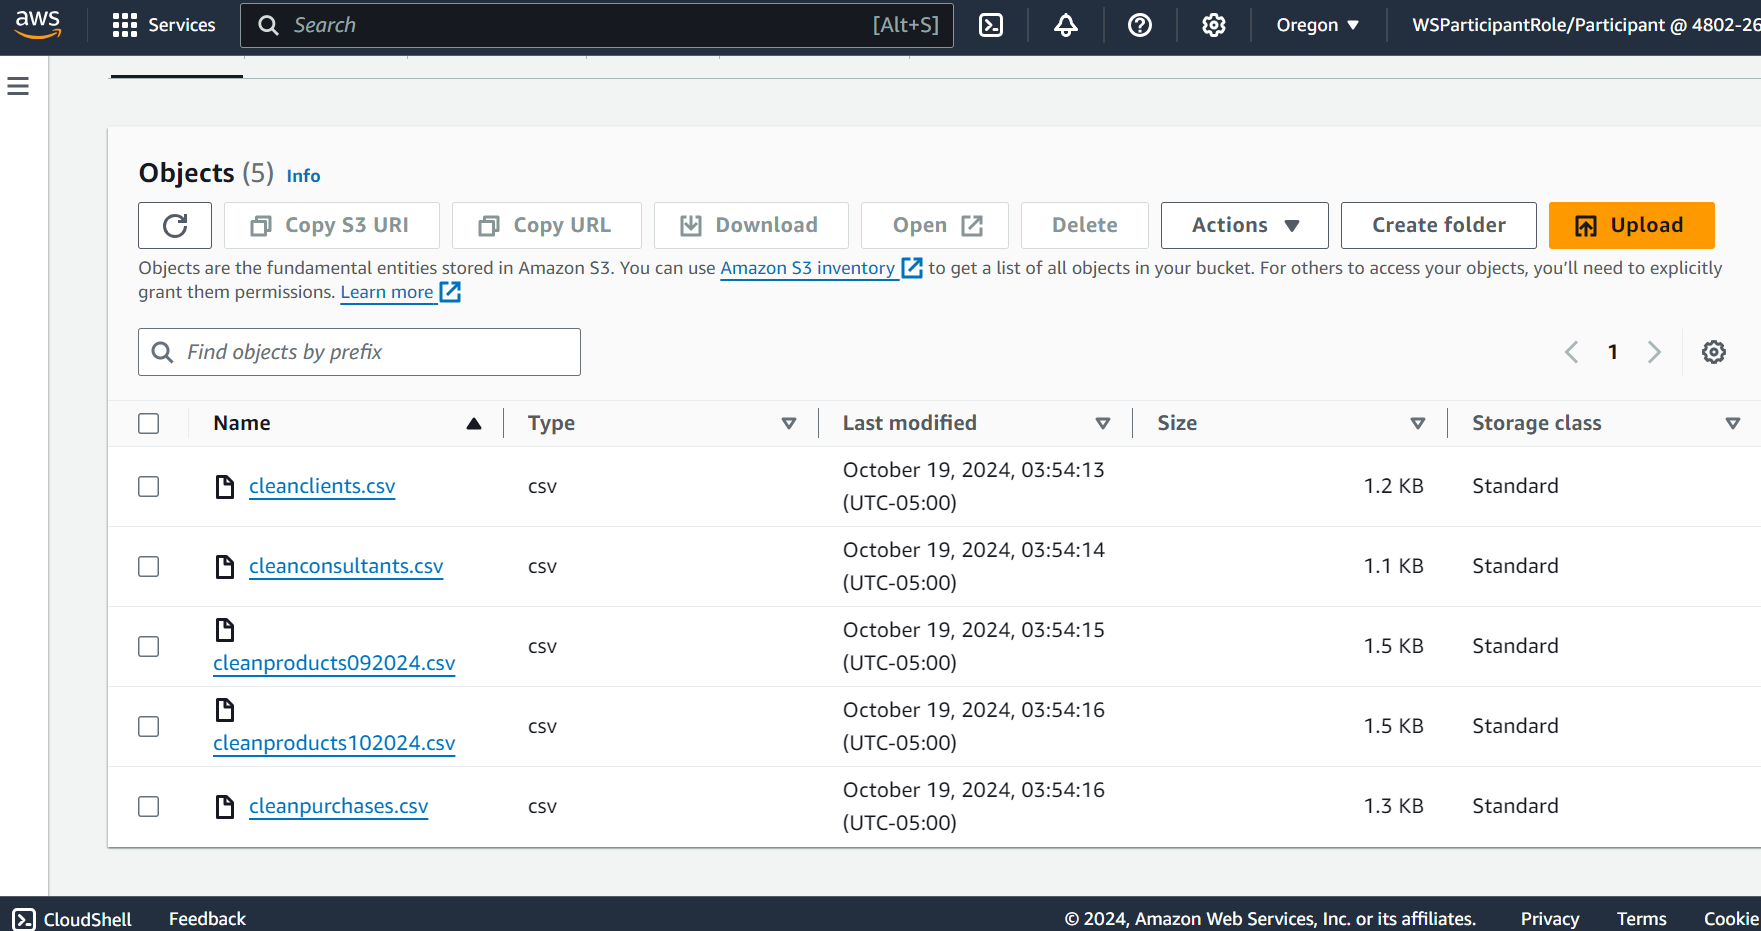

### **2. AWS Personalize ML training and testing**

Below we will develop a model that can help us get insights of popularity of a product based on the purchases and attributes relationship of product and client.

In [ ]:
# Function to process data and generate insights for AWS Personalize
def process_and_generate_insights():
    for key, file_path in file_paths.items():
        # Generate insights for AWS Personalize and save them on the bucket_personalize
        if key == 'purchases':
            product_popularity = df.groupby('desproducto').agg({'quantity': 'sum'}).reset_index()
            product_popularity.columns = ['Product', 'Total_Quantity_Sold']
            product_popularity.to_csv('product_popularity.csv', index=False)
            upload_to_s3('product_popularity.csv', 'insights/product_popularity.csv', bucket_personalize)

            # Create attributes relationship data
            attributes_relationship = df[['Client', 'desproducto']].merge(
                df[['desproducto', 'attributes']], on='desproducto', how='left'
            ).drop_duplicates()
            attributes_relationship.to_csv('attributes_relationship.csv', index=False)
            upload_to_s3('attributes_relationship.csv', 'insights/attributes_relationship.csv', bucket_personalize)

    print("\nData insights generation completed.")

# Function to create Personalize dataset group
def create_dataset_group(group_name):
    response = personalize_client.create_dataset_group(
        name=group_name
    )
    return response['datasetGroup']['datasetGroupArn']

# Function to create datasets
def create_datasets(dataset_group_arn):
    # Specify the schema for the datasets
    interactions_schema = {
        "type": "record",
        "name": "Interactions",
        "namespace": "com.amazonaws.personalize.schema",
        "fields": [
            {"name": "USER_ID", "type": "string"},
            {"name": "ITEM_ID", "type": "string"},
            {"name": "TIMESTAMP", "type": "long"},
            {"name": "QUANTITY", "type": "float"}
        ],
        "version": "1.0"
    }

    items_schema = {
        "type": "record",
        "name": "Items",
        "namespace": "com.amazonaws.personalize.schema",
        "fields": [
            {"name": "ITEM_ID", "type": "string"},
            {"name": "ATTRIBUTES", "type": "string"}
        ],
        "version": "1.0"
    }

    users_schema = {
        "type": "record",
        "name": "Users",
        "namespace": "com.amazonaws.personalize.schema",
        "fields": [
            {"name": "USER_ID", "type": "string"},
            {"name": "AGE", "type": "int"}
        ],
        "version": "1.0"
    }

    # Create Interactions dataset
    interactions_response = personalize_client.create_dataset(
        datasetGroupArn=dataset_group_arn,
        datasetType='INTERACTIONS',
        name='Interactions Dataset',
        schema=json.dumps(interactions_schema),
        dataSource={
            'dataLocation': f's3://{bucket_personalize}/insights/attributes_relationship.csv'
        },
        roleArn='arn:aws:iam::480226593936:role/aws-service-role/sagemaker.amazonaws.com/AWSServiceRoleForAmazonSageMakerNotebooks'
    )

    # Create Items dataset
    items_response = personalize_client.create_dataset(
        datasetGroupArn=dataset_group_arn,
        datasetType='ITEMS',
        name='Items Dataset',
        schema=json.dumps(items_schema),
        dataSource={
            'dataLocation': f's3://{bucket_personalize}/insights/product_popularity.csv'
        },
        roleArn='arn:aws:iam::480226593936:role/aws-service-role/sagemaker.amazonaws.com/AWSServiceRoleForAmazonSageMakerNotebooks'
    )

    # Create Users dataset
    users_response = personalize_client.create_dataset(
        datasetGroupArn=dataset_group_arn,
        datasetType='USERS',
        name='Users Dataset',
        schema=json.dumps(users_schema),
        dataSource={
            'dataLocation': f's3://{bucket_personalize}/insights/product_popularity.csv'  # Adjust this if needed
        },
        roleArn='arn:aws:iam::480226593936:role/aws-service-role/sagemaker.amazonaws.com/AWSServiceRoleForAmazonSageMakerNotebooks'
    )

    return interactions_response, items_response, users_response

# Function to create and train a solution
def create_and_train_solution(dataset_group_arn):
    # Create a solution
    solution_response = personalize_client.create_solution(
        name='MyPersonalizeSolution',
        datasetGroupArn=dataset_group_arn,
        recipeArn='arn:aws:personalize:::recipe/aws-user-personalization'  # You can choose other recipes as needed
    )

    solution_arn = solution_response['solution']['solutionArn']

    # Wait for the solution to be created
    time.sleep(60)  # Adjust this time based on your needs; you may want to implement a better waiting mechanism

    # Create a solution version
    solution_version_response = personalize_client.create_solution_version(
        solutionArn=solution_arn,
        trainingMode='FULL'
    )

    version_arn = solution_version_response['solutionVersion']['solutionVersionArn']

    # Wait for the solution version to be created
    time.sleep(60)  # Adjust this time based on your needs

    return solution_arn, version_arn

# Function to create a campaign
def create_campaign(solution_version_arn):
    campaign_response = personalize_client.create_campaign(
        name='MyPersonalizeCampaign',
        solutionVersionArn=solution_version_arn,
        minProvisionedTPS=1  # Minimum provisioned transactions per second
    )

    return campaign_response['campaign']['campaignArn']

# Run the process and insights generation
process_and_generate_insights()

# Create dataset group
dataset_group_arn = create_dataset_group("MyDatasetGroup")

# Create datasets
create_datasets(dataset_group_arn)

# Create and train a solution
solution_arn, version_arn = create_and_train_solution(dataset_group_arn)

# Create a campaign
campaign_arn = create_campaign(version_arn) # A campaign is the final chosen model after training and testing

print(f'Campaign created: {campaign_arn}')

### Now that we have the chosen campaign model after training and testing, we can process our clean data using this model:

In [ ]:
# Function to get recommendations from the campaign
def get_recommendations(campaign_arn, user_id, num_results=10):
    response = personalize_runtime_client.get_recommendations(
        campaignArn=campaign_arn,
        userId=user_id,
        numResults=num_results
    )
    return response['itemList']

def process_recommendations(campaign_arn, user_id):
    # Get recommendations
    recommendations = get_recommendations(campaign_arn, user_id)

    # Convert recommendations to DataFrame
    recommendations_df = pd.DataFrame(recommendations)

    # Save recommendations to S3
    recommendations_file = 'recommendations.csv'
    recommendations_df.to_csv(recommendations_file, index=False)
    upload_to_s3(recommendations_file, f'recommendations/{recommendations_file}', bucket_personalize)

# We would have to generate a campaign ARN and user ID
campaign_arn = 'your_campaign_arn'
user_id = 'example_user_id'

# Process and save recommendations
process_recommendations(campaign_arn, user_id)

### **3. AWS SageMaker ML training and testing**
Below we will do a similar process as above, but we will use it to create a ML model using Random Forest Regression algorithm to predict the next month's sales and store the predictions in an S3 bucket.



In [ ]:
# Function to create and train a SageMaker model
def train_model(training_job_name, role, input_data, output_data):
    response = sagemaker_client.create_training_job(
        TrainingJobName=training_job_name,
        RoleArn=role,
        AlgorithmSpecification={
            'TrainingImage': '174872318107.dkr.ecr.us-west-2.amazonaws.com/sagemaker-random-forest:latest',  # Random Forest container
            'TrainingInputMode': 'File',
        },
        InputDataConfig=[
            {
                'ChannelName': 'training',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': input_data,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'csv',
            },
        ],
        OutputDataConfig={
            'S3OutputPath': output_data
        },
        ResourceConfig={
            'InstanceType': 'ml.m5.large',
            'InstanceCount': 1,
            'VolumeSizeInGB': 10,
        },
        StoppingCondition={
            'MaxRuntimeInSeconds': 3600
        }
    )
    print(f'Training job {training_job_name} started.')

# Function to invoke a SageMaker endpoint
def invoke_endpoint(endpoint_name, payload):
    response = sagemaker_runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=payload
    )
    return json.loads(response['Body'].read())

# Function to save predictions to S3
def save_predictions(predictions, file_name):
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv(file_name, index=False)
    upload_to_s3(file_name, f'predictions/{file_name}', bucket_processedsagemaker)

# Example usage
def process_sales_data():
    training_job_name = 'sales-forecasting-job'
    role = 'your-iam-role-arn'  # Replace with your IAM role ARN
    input_data = f's3://{bucket_processedsagemaker}/cleaned_data/'  # Change to your actual cleaned data path
    output_data = f's3://{bucket_processedsagemaker}/model_output/'

    # Step 1: Train the model
    train_model(training_job_name, role, input_data, output_data)

    # Step 2: Wait for the training job to finish
    while True:
        response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
        status = response['TrainingJobStatus']
        print(f'Training job status: {status}')
        if status in ['Completed', 'Failed', 'Stopped']:
            break
        time.sleep(60)

    # Step 3: Create a SageMaker endpoint for the model (if not already created)
    endpoint_name = 'sales-forecasting-endpoint'  # Replace with your desired endpoint name
    try:
        sagemaker_client.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName='sales-forecasting-config'  # Replace with your endpoint config name if you have one
        )
    except Exception as e:
        print(f'Error creating endpoint: {str(e)}')

    # Step 4: Invoke the endpoint to get predictions for next month's sales
    payload = '{"instances": [{"feature1": value1, "feature2": value2, ...}]}'  # Replace with actual feature values
    predictions = invoke_endpoint(endpoint_name, payload)

    # Step 5: Save predictions
    predictions_file = 'sales_predictions.csv'
    save_predictions(predictions, predictions_file)

# Process sales data through SageMaker
process_sales_data()

### **4. AWS Comprehend training and testing**
Finally, we will se the same process but to implement an AI solution for NLP of PDFs of documented WhatsApp chats. We want insights such as sentiment score to understand positive or negative feedback from a specific product, as well as insights that could be related to the attributes of the client.

In [ ]:
# Function to analyze sentiment using AWS Comprehend
def analyze_sentiment(text):
    response = comprehend_client.detect_sentiment(
        Text=text,
        LanguageCode='en'  # Change to appropriate language code if necessary
    )
    return response['Sentiment'], response['SentimentScore']

# Function to process feedback and generate insights
def process_feedback(feedback_df):
    insights = []
    for index, row in feedback_df.iterrows():
        sentiment, sentiment_score = analyze_sentiment(row['feedback'])  # Assuming 'feedback' is the column with text
        insights.append({
            'feedback': row['feedback'],
            'product_id': row['product_id'],  # Assuming there's a product_id column
            'client_id': row['client_id'],    # Assuming there's a client_id column
            'sentiment': sentiment,
            'sentiment_score': sentiment_score
        })
    return insights

# Function to save insights to S3
def save_insights(insights, file_name):
    insights_df = pd.DataFrame(insights)
    insights_df.to_csv(file_name, index=False)
    upload_to_s3(file_name, f'insights/{file_name}', bucket_processedcomprehend)

# Function to extract text from PDF and structure it
def extract_text_from_pdf(pdf_file):
    feedback_list = []
    with pdfplumber.open(pdf_file) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                # Assuming the feedback is structured in some way, e.g., in lines
                for line in text.split('\n'):
                    # Here you would parse the line to extract product_id and client_id
                    # This example assumes each line is structured as "client_id, product_id, feedback"
                    parts = line.split(', ')
                    if len(parts) >= 3:
                        feedback_list.append({
                            'client_id': parts[0],
                            'product_id': parts[1],
                            'feedback': parts[2]
                        })
    return pd.DataFrame(feedback_list)

# Example usage
def analyze_customer_feedback():
    # Load your customer feedback data from a PDF
    feedback_data = extract_text_from_pdf('chatcliente.pdf')  # Changed the file name here

    # Step 1: Process feedback and generate insights
    insights = process_feedback(feedback_data)

    # Step 2: Save insights to S3
    insights_file = 'feedback_insights.csv'
    save_insights(insights, insights_file)

# Analyze customer feedback through AWS Comprehend
analyze_customer_feedback()

### **5. Backend to Dashboard**
We can continue repeating these combinations of data processing to generate meta data as in our architecture but for the purpose of this example we haven't done so.

Below there is an example of how we would fetch our insights' data stored in the processed data buckets processedsagemaker and processedcomprehend in AWS S3 using Boto3 and the BackEnd Framework (Flask) to interact with Belcorp's website.

In [ ]:
# Creating the Flask Application to ferch data from S3 bucket and display on webpage:

from flask import Flask, jsonify, render_template
import requests
import boto3
import json

app = Flask(__name__)

# Load S3 client for AWS interactions
s3_client = boto3.client('s3')

# Function to retrieve processed data from an S3 bucket
def get_processed_data(bucket_name, file_key):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        content = response['Body'].read().decode('utf-8')
        return json.loads(content)
    except Exception as e:
        print(f"Error retrieving data from S3: {str(e)}")
        return None

# Function to retrieve access token for Belcorp's APIs using OAuth2
def get_access_token():
    url = "https://api-qa.belcorp.biz/oauth/token"
    auth = ('client_id', 'client_secret')
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    data = {'grant_type': 'client_credentials'}

    response = requests.post(url, auth=auth, headers=headers, data=data)

    if response.status_code == 200:
        access_token = response.json().get('access_token')
        return access_token
    else:
        print(f"Error retrieving access token: {response.status_code}")
        return None

# Function to call Belcorp's API to get catalog data
def get_catalog_data(access_token):
    url = "https://api-qa.belcorp.biz/catalogs/PE"
    headers = {'x-access-token': access_token}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error retrieving catalog data: {response.status_code}")
        return None

# Route to render the dashboard
@app.route('/')
def dashboard():
    # Retrieve processed data from S3
    sagemaker_data = get_processed_data('processedsagemaker', 'insights/sagemaker_results.json')
    comprehend_data = get_processed_data('processedcomprehend', 'insights/comprehend_sentiment.json')
    personalize_data = get_processed_data('processedpersonalize', 'insights/personalize_recommendations.json')

    # Retrieve API data from Belcorp
    access_token = get_access_token()
    if not access_token:
        return jsonify({"error": "Failed to retrieve access token"}), 500

    catalog_data = get_catalog_data(access_token)
    if not catalog_data:
        return jsonify({"error": "Failed to retrieve catalog data"}), 500

    # Render the data in the dashboard
    return render_template(
        'dashboard.html',
        sagemaker_data=sagemaker_data,
        comprehend_data=comprehend_data,
        personalize_data=personalize_data,
        catalog_data=catalog_data
    )

if __name__ == "__main__":
    app.run(debug=True)